## 매우 간단한 CNN 모델 훈련

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Load in our libraries
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import os
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn')
sns.set(font_scale=1.5) 
from os.path import join
import tensorflow as tf
from tensorflow import keras
from keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


%matplotlib inline

데이터 로드

In [30]:
df=pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/datasets/WM-811K/LSWMD.pkl")

In [31]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


waferMapDim df에 컬럼으로 추가

In [35]:
def return_dim(img):
    return (img.shape[0], img.shape[1])

df['waferMapDim']=df.waferMap.apply(return_dim)

In [38]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]],"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]],"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]],"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]],"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]],"(45, 48)"


문자 컬럼들 숫자로 변환  
trianTestLabel->failureNum    
filureType-> trainTestNum

In [52]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type,'trainTestNum':mapping_traintest})

In [53]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]],"(45, 48)",8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]],"(45, 48)",8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]],"(45, 48)",8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]],"(45, 48)",8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]],"(45, 48)",8,0


failureType==[[none]]인 행 제거

In [54]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

이미지 resize

In [56]:
import cv2

def img_resize(img):
  resized_img=cv2.resize(img,(26,26),interpolation=cv2.INTER_AREA)
  return resized_img

def resized_dim(dim):
  dim=(26,26)
  return dim

In [58]:
df_withpattern.waferMap=df_withpattern.waferMap.apply(img_resize)
df_withpattern.waferMapDim=df_withpattern.waferMapDim.apply(resized_dim)
df_withlabel.waferMap=df_withlabel.waferMap.apply(img_resize)
df_withlabel.waferMapDim=df_withlabel.waferMapDim.apply(resized_dim)

In [61]:
no_missing_df=pd.concat([df_withpattern,df_withlabel])
no_missing_df.head()

,index,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,...",1683.0,lot1,20.0,[[Training]],[[Loc]],"(26, 26)",4,0
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,...",2460.0,lot2,12.0,[[Training]],[[Edge-Loc]],"(26, 26)",2,0
2,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,...",2460.0,lot2,13.0,[[Training]],[[Edge-Loc]],"(26, 26)",2,0
3,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,...",2460.0,lot2,14.0,[[Training]],[[Edge-Loc]],"(26, 26)",2,0
4,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,...",2460.0,lot2,15.0,[[Training]],[[Edge-Loc]],"(26, 26)",2,0


RAM 용량을 위해 불필요한 변수 제거

In [62]:
del df, df_withpattern,df_withlabel,df_nonpattern

X_train,X_test,y_train,y_test 추출

In [154]:
X_train=(no_missing_df[no_missing_df['trainTestNum']==0]).waferMap.values
X_test=(no_missing_df[no_missing_df['trainTestNum']==1]).waferMap.values
y_train=(no_missing_df[no_missing_df['trainTestNum']==0]).failureNum.values
y_test=(no_missing_df[no_missing_df['trainTestNum']==1]).failureNum.values
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((71980,), (126489,), (71980,), (126489,))

훈련을 위해 자료 reshape

In [155]:
X_train=np.concatenate(X_train).reshape([-1,26,26,1])
X_test=np.concatenate(X_test).reshape([-1,26,26,1])
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((71980, 26, 26, 1), (126489, 26, 26, 1), (71980,), (126489,))

모델 생성

In [168]:
from sklearn.datasets import load_sample_image
import numpy as np
import tensorflow as tf
from tensorflow import keras

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(26, 26,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

모델 summary

In [169]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 24, 24, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_3 (Flatten)         (None, 576)              

int형을 모델이 거부하므로 float형으로 데이터셋 전환

In [159]:
X_train=X_train.astype(float)
y_train=y_train.astype(float)

훈련 진행

In [170]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



history=model.fit(X_train, y_train, validation_split=0.2, epochs=20)

Epoch 1/20
1800/1800 [==============================] - 7s 4ms/step - loss: 0.4306 - accuracy: 0.8591 - val_loss: 0.2874 - val_accuracy: 0.9410
Epoch 2/20
1800/1800 [==============================] - 6s 3ms/step - loss: 0.2043 - accuracy: 0.9313 - val_loss: 0.9341 - val_accuracy: 0.6977
Epoch 3/20
1800/1800 [==============================] - 6s 3ms/step - loss: 0.1551 - accuracy: 0.9472 - val_loss: 0.4143 - val_accuracy: 0.8864
Epoch 4/20
1800/1800 [==============================] - 6s 3ms/step - loss: 0.1263 - accuracy: 0.9562 - val_loss: 0.3011 - val_accuracy: 0.9132
Epoch 5/20
1800/1800 [==============================] - 6s 3ms/step - loss: 0.1039 - accuracy: 0.9643 - val_loss: 0.7228 - val_accuracy: 0.7724
Epoch 6/20
1800/1800 [==============================] - 6s 3ms/step - loss: 0.0865 - accuracy: 0.9693 - val_loss: 0.3907 - val_accuracy: 0.8882
Epoch 7/20
1800/1800 [==============================] - 6s 3ms/step - loss: 0.0730 - accuracy: 0.9735 - val_loss: 0.9239 - val_accuracy:

결과 시각화

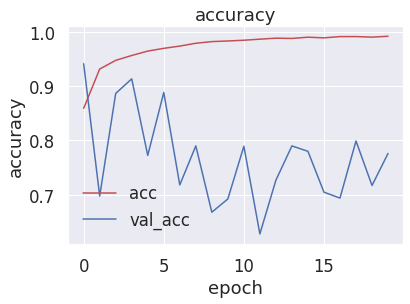

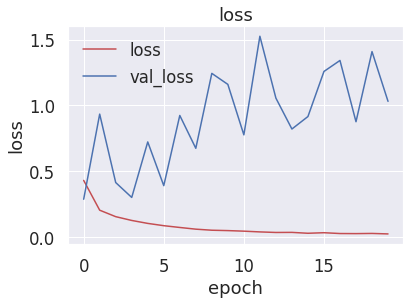

In [172]:
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['acc','val_acc'])
plt.show()

plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])
plt.show()

In [173]:
preds=model.predict(X_test)

In [201]:
y_pred=np.argmax(preds,axis=1)

In [205]:
test_acc=(sum(y_pred==y_test)/(y_pred==y_test).shape[0])*100
test_acc

84.50932492153468